## Sentiment Analysis on Twitter Data

In [1]:
### Reading Libraries
import tweepy as tw
import numpy as np
import pandas as pd
import string
import spacy
from matplotlib.pyplot import imread
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import re
import seaborn as sns

In [2]:
## Key and Access tokens for twitter account
consumer_key = 'C7kHXHU16aQUWWHZaRttFXRzx'
consumer_secret = 'sDko6mIHPPzkecrGHIg81ezsEPcsiOU4oQI6kDtY28QOFgva42'
access_token = '1335135884094533633-xhcZq2pJqTyNrs7bLPJXpDdVa86mzd'
access_token_secret = 'yBq2kgPWPt8KVRmS3N4WfObPXNKSc7r9kkmXeVuWo5h4h'

In [3]:
## Authenticating Twitter API
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit= True)

In [4]:
## Extracting Tweets from Narendra Modi's Twitter account
hashtag = 'narendramodi'
query = tw.Cursor(api.search, q=hashtag+ '-filter:retweets', lang = 'en').items(1000)
tweets = [{"Tweets": tweet.text} for tweet in query]


In [5]:
tweets[0:5]

[{'Tweets': '@torquetargetted @SavitaVantagodi @srivatsayb @narendramodi no jokes on you, get out of the sanghi mindset and thin… https://t.co/Mli8VGpNMm'},
 {'Tweets': '@Raveendran95 @SreeSrinair @narendramodi @HMOIndia @nsitharamanoffc Must be banned'},
 {'Tweets': '@narendramodi @PMOIndia  Dear Sir, please impose sanctions on Mynmar and support democracy in that country. If we d… https://t.co/70Y7CeHdxo'},
 {'Tweets': 'India has seen a new dawn of economic development under the leadership of PM Shri @narendramodi &amp; FM Smt… https://t.co/lgT07Alc4X'},
 {'Tweets': '#Budget2021 Natl Research Foundation outlay at 50 thousand Cr rupees over 5 yrs\n@nsitharaman @narendramodi… https://t.co/EmxhRkFJnd'}]

In [6]:
df = pd.DataFrame(tweets)

In [7]:
df.shape

(1000, 1)

In [8]:
## Cleaning Text
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r':', '', text)
    return text
    

In [9]:
df['Tweets']= df['Tweets'].apply(clean_text)

In [10]:
df.head()

,Tweets
0,"no jokes on you, get out of the sanghi min..."
1,Must be banned
2,"Dear Sir, please impose sanctions on Mynmar..."
3,India has seen a new dawn of economic developm...
4,Budget2021 Natl Research Foundation outlay at ...


In [11]:
df = [Tweets.strip() for Tweets in df.Tweets]

In [12]:
df[0:10]

['no jokes on you, get out of the sanghi mindset and thin…',
 'Must be banned',
 'Dear Sir, please impose sanctions on Mynmar and support democracy in that country. If we d…',
 'India has seen a new dawn of economic development under the leadership of PM Shri  &amp; FM Smt…',
 'Budget2021 Natl Research Foundation outlay at 50 thousand Cr rupees over 5 yrs\n …',
 'Accident occurred on National Highway No. 326 under control of Central Govt. due to failure…',
 'The PM Gareeb Kalyan Yojana, the three Aatmanirbhar packages and announcements made later were five mini-budgets in…',
 'The investment on health infrastructure in this budget has increased substantially. Progressively, as institutions…',
 "Let's trend reducefuelprice\n\ngovernment NarendraModi YOUTH",
 'As  said  is doing  a corporate puppet is working on directions of corporates…']

In [13]:
## Reading Afinn data for Sentiment Values
afinn = pd.read_csv('Afinn.csv', sep=',', encoding= 'latin-1')
afinn.head()

,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [14]:
## Tokenizing the data
from nltk import tokenize
sentences = tokenize.sent_tokenize(''.join(df))
sentences[0:10]

['no jokes on you, get out of the sanghi mindset and thin…Must be bannedDear Sir, please impose sanctions on Mynmar and support democracy in that country.',
 'If we d…India has seen a new dawn of economic development under the leadership of PM Shri  &amp; FM Smt…Budget2021 Natl Research Foundation outlay at 50 thousand Cr rupees over 5 yrs\n …Accident occurred on National Highway No.',
 '326 under control of Central Govt.',
 'due to failure…The PM Gareeb Kalyan Yojana, the three Aatmanirbhar packages and announcements made later were five mini-budgets in…The investment on health infrastructure in this budget has increased substantially.',
 "Progressively, as institutions…Let's trend reducefuelprice\n\ngovernment NarendraModi YOUTHAs  said  is doing  a corporate puppet is working on directions of corporates…Stretch from Jinjira Bazar to Sampriti Flyover is damaged for last…_  What mind ur language???",
 'Main kuch bhi gala…Free food grain to 800 million people, free cooking gas for 80 m

In [15]:
tw_df = pd.DataFrame(sentences)
tw_df.columns = ['Sentences']

In [16]:
tw_df.head()

,Sentences
0,"no jokes on you, get out of the sanghi mindset..."
1,If we d…India has seen a new dawn of economic ...
2,326 under control of Central Govt.
3,"due to failure…The PM Gareeb Kalyan Yojana, th..."
4,"Progressively, as institutions…Let's trend red..."


In [17]:
affinity_scores = afinn.set_index('word')['value'].to_dict()

In [18]:
nlp = spacy.load('en_core_web_sm')

In [22]:
### Lemmatization and generating sentiment scores
sentiment_lexicon = affinity_scores
def cal_sentiment(text: str = None):
    sent_score = 0
    if text:
        sentence = nlp(text)
        for word in sentence:
            sent_score += sentiment_lexicon.get(word.lemma_, 0)
            
            return sent_score


In [23]:
## Testing whether scores are correct
cal_sentiment(text='great')

3

In [24]:
## Applying sentiment scores for twitter data and creating a column
tw_df['Sentiment_value'] = tw_df['Sentences'].apply(cal_sentiment)

In [25]:
## Getting word count for a particular tweet and creating a column
tw_df['word_count'] = tw_df['Sentences'].str.strip().apply(len)


In [26]:
tw_df.head()

,Sentences,Sentiment_value,word_count
0,"no jokes on you, get out of the sanghi mindset...",-1,152
1,If we d…India has seen a new dawn of economic ...,0,226
2,326 under control of Central Govt.,0,34
3,"due to failure…The PM Gareeb Kalyan Yojana, th...",0,214
4,"Progressively, as institutions…Let's trend red...",0,261


In [27]:
## Sorting Sentiment values in descending order
tw_df.sort_values(by='Sentiment_value', ascending= False)

,Sentences,Sentiment_value,word_count
149,Glad that…Sir...i think you should also tagDea...,3,94
133,Thank you Hon PM…_ksaurav Yay yes!,2,40
79,PEACE by submarine.,2,19
188,Strong Infrastructure\n3.,2,24
216,Thanks Honourable PM Union Minister……Bringbac...,2,377
...,...,...,...
241,No…_chu _gadkari Modi has screwed the nation...,-1,565
183,no.,-1,3
111,Shame on you \nFarmersProtest \nSHAMEONMODIGO...,-2,186
116,Pathetic situation of India under…Budget outla...,-2,102


In [28]:
tw_df['Sentiment_value'].describe()

count    328.000000
mean       0.100610
std        0.535241
min       -2.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: Sentiment_value, dtype: float64

In [29]:
## Positive Sentiments
pos_sentiment = tw_df[tw_df['Sentiment_value']>0]
pos_sentiment

,Sentences,Sentiment_value,word_count
6,Please provide me STREET LIGHTS and DRAINAGE S...,1,544
9,Thank you Hon PM…This is our new startup for s...,2,85
10,Please consider sir.…You surely are a dumbo.,1,44
13,Substantial…Under leadership of Prime Minister...,1,80
39,Please consider sir.,1,20
44,Please Click on the line…So far all announceme...,1,209
45,Big boost for R&amp;D. Congratulation…Save The...,1,454
55,Thank u ji\n\nAtmaNirbharBharatKaBudget\nFarm...,2,461
56,Respected PM and Amit Sh…AatmanirbharBharatKaB...,2,236
63,Hope the money will be wisely spent on actual ...,2,267


In [30]:
## Negative Sentiments
neg_sentiment = tw_df[tw_df['Sentiment_value']<0]
neg_sentiment

,Sentences,Sentiment_value,word_count
0,"no jokes on you, get out of the sanghi mindset...",-1,152
49,No condolences towards…Modi ji finally gives i...,-1,62
111,Shame on you \nFarmersProtest \nSHAMEONMODIGO...,-2,186
116,Pathetic situation of India under…Budget outla...,-2,102
173,"Shame on pm modi.Day 55\n , madam, in malnad w...",-2,81
183,no.,-1,3
241,No…_chu _gadkari Modi has screwed the nation...,-1,565
261,No doubt.👏👏👍…SamePayForSameWork\nPayRevisionFr...,-1,493
321,No more endless paper prints!,-1,29


In [31]:
## Neutral Sentiments
neutral_sentiment = tw_df[tw_df['Sentiment_value'] == 0]
neutral_sentiment

,Sentences,Sentiment_value,word_count
1,If we d…India has seen a new dawn of economic ...,0,226
2,326 under control of Central Govt.,0,34
3,"due to failure…The PM Gareeb Kalyan Yojana, th...",0,214
4,"Progressively, as institutions…Let's trend red...",0,261
5,Main kuch bhi gala…Free food grain to 800 mill...,0,276
...,...,...,...
323,?Shall we write another obituary.,0,33
324,?another epitaph?,0,17
325,Immediate 302 in SS…shame on delhimetro for ru...,0,76
326,"Mangu Singh and Pratibha,…_Surya Hey just fo...",0,67


In [32]:
## Creating index column
tw_df['index'] = range(0,len(tw_df))

In [33]:
tw_df.shape

(328, 4)

<AxesSubplot:xlabel='index', ylabel='Sentiment_value'>

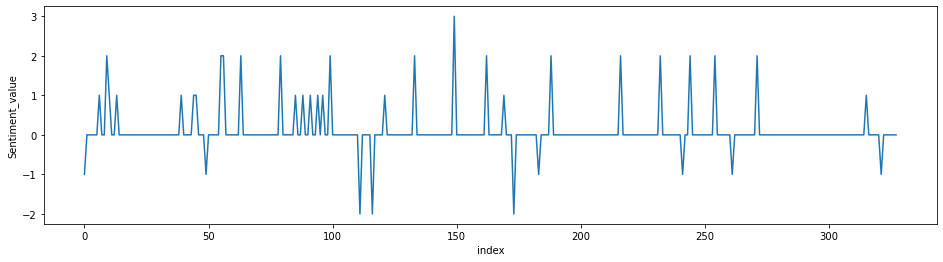

In [34]:
plt.figure(figsize=(16, 4))
sns.lineplot(y= 'Sentiment_value', x='index', data= tw_df)

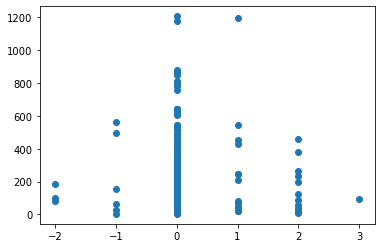

In [35]:
plt.scatter(tw_df['Sentiment_value'], tw_df['word_count'])